In [2]:
import torch
from audiffuse import Audiffuse
from es_dataset import EpidemicSoundDataset
from lightning.pytorch.utilities.deepspeed import convert_zero_checkpoint_to_fp32_state_dict
from diffusers.models import AutoencoderKL

import matplotlib.pyplot as plt

/home/korte/micromamba/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-09-06 17:18:24,292] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
# model = Audiffuse.load_from_checkpoint('/scratch/korte/audiffuse/full_model.ckpt')
# model = model.to('cuda')

In [4]:
model = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse")
model = model.to('cuda')

In [6]:
model.save_pretrained("/scratch/korte/audiffuse/autoencoder_ckpt")

In [6]:
dataset = EpidemicSoundDataset('/fastscratch/korte/es_dataset/')

In [7]:
img = torch.stack([dataset[110]['album_art'], dataset[110]['album_art']])

In [8]:
with torch.no_grad():
    encoding = model.encode(img.to('cuda')).latent_dist.sample()

In [11]:
torch.isnan(encoding).any()

tensor(False, device='cuda:0')

In [10]:
encoding.max(), encoding.min(), encoding.mean(), encoding.std()

(tensor(25.9357, device='cuda:0'),
 tensor(-21.5042, device='cuda:0'),
 tensor(3.4938, device='cuda:0'),
 tensor(7.4437, device='cuda:0'))

In [30]:
# encoding = torch.randn_like(encoding)

noise = torch.randn_like(encoding)
encoding = model.noise_scheduler.add_noise(encoding, noise, torch.tensor(300))

decoding = model.first_stage_model.decode(encoding).sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


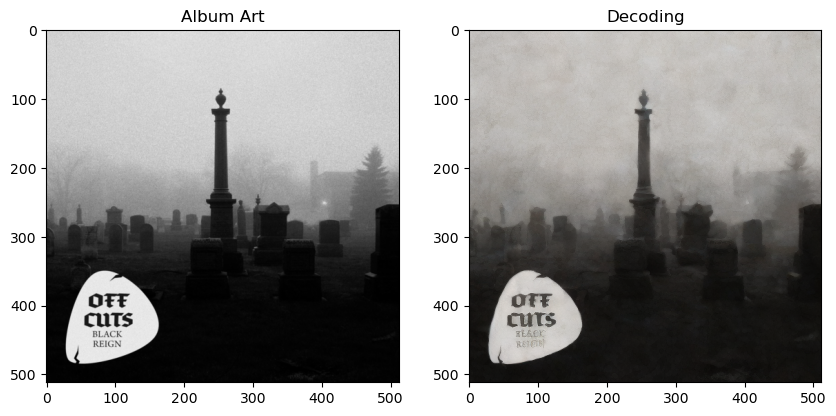

In [31]:
album_art = img.permute(1, 2, 0).numpy() * 0.5 + 0.5

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(album_art)
axs[0].set_title('Album Art')
axs[1].imshow(decoding.squeeze().permute(1, 2, 0).cpu().detach().numpy() * 0.5 + 0.5)
axs[1].set_title('Decoding')
plt.show()